In [1]:
import torch
from JetGraphProducer import JetGraphProducer
import numpy as np, awkward as ak
import uproot

We need to calculate MT on the fly since the version with AK15 Jets is not stored in the ntuples. This will be loaded by the `JetGraphProducer` and ran event-by-event

In [2]:
def mt(event):
    """
    Calculates the transverse mass MT and RT (closely related calcs)
    """
    met_x = np.cos(event.METPhi) * event.MET
    met_y = np.sin(event.METPhi) * event.MET
    jet_phi = event["JetsAK15/JetsAK15.fCoordinates.fPhi"][1]
    jet_pt = event["JetsAK15/JetsAK15.fCoordinates.fPt"][1]
    jet_e = event["JetsAK15/JetsAK15.fCoordinates.fE"][1]
    jet_x = np.cos(jet_phi) * jet_pt
    jet_y = np.sin(jet_phi) * jet_pt
    # jet_e = np.sqrt(jets.mass2 + jets.pt**2)
    # m^2 + pT^2 = E^2 - pT^2 - pz^2 + pT^2 = E^2 - pz^2
    pz = jet_pt * np.sinh(event["JetsAK15/JetsAK15.fCoordinates.fEta"][1])
    transverse_e = np.sqrt(jet_e**2 - pz**2)
    mt = np.sqrt( (transverse_e + event.MET)**2 - (jet_x + met_x)**2 - (jet_y + met_y)**2 )

    return mt

We load the signal and background data as graphs. The frist time the data is loaded, the rootfiles are processed into `torch_geometric.data.InMemoryDataset` objects and also stored on diks

In [3]:
signal = JetGraphProducer(
    "test_data",
    n_store_jets=2,
    use_lund_decomp=True,
    n_lund_vars=5,
    weights="xsec",
    extra_obs_to_load=["MET", "METPhi"],
    extra_obs_to_compute_per_event=[mt],
    input_format="TreeMaker2",
    jet_collection="JetsAK15",
    verbose=True,
    mask=True,
    max_events_to_process=3000,
    label=1.,
)

Processing...


Processing test_data/madpt300_mz250_mdark1_rinv0.7.root


  0%|          | 0/3000 [00:00<?, ?it/s]/Users/eth-svj/brendan/JetGraphProducer.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(adjacency, dtype=torch.long),
100%|██████████| 3000/3000 [06:47<00:00,  7.36it/s]
Done!


tensor([[     2,      4,     63,  ..., 587170, 587171, 587171],
        [    63,     63,      2,  ..., 587171, 587168, 587170]])

In [5]:

background = JetGraphProducer(
    "test_data_bkg",
    n_store_jets=2,
    use_lund_decomp=True,
    n_lund_vars=5,
    weights="xsec",
    extra_obs_to_load=["MET", "METPhi"],
    extra_obs_to_compute_per_event=[mt],
    input_format="TreeMaker2",
    jet_collection="JetsAK15",
    verbose=True,
    mask=True,
    max_events_to_process=3000,
    label=0.,
)

Processing...


Processing test_data_bkg/6_RA2AnalysisTree.root


  0%|          | 0/3000 [00:00<?, ?it/s]/Users/eth-svj/brendan/JetGraphProducer.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(adjacency, dtype=torch.long),
100%|██████████| 3000/3000 [10:22<00:00,  4.82it/s]
Done!


We now preprocess the data by normalizing the node features and splitting it into training and testing, and merging them into one labelled dataset

In [6]:
from LundTreeUtilities import OnTheFlyNormalizer
from torch.utils.data import ConcatDataset

signal_training = signal[::2][:int(len(signal)/2*0.8)]
signal_testing = signal[::2][int(len(signal)/2*0.8):]

background_training = background[:int(len(background)*0.8)]
background_testing = background[int(len(background)*0.8):]

weigths_signal_training = signal_training.w
weigths_background_training = background_training.w
weigths_signal_testing = signal_testing.w
weigths_background_testing = background_testing.w

means, stds = 0., 0.

for graph in signal_training:
    means =+ graph.x.sum(dim=0)*graph.w
for graph in background_training:
    means =+ graph.x.sum(dim=0)*graph.w
for graph in signal_training:
    stds += ((graph.x - means)**2).sum(dim=0)*graph.w
for graph in background_training:
    stds += ((graph.x - means)**2).sum(dim=0)*graph.w

stds /= (signal_training.w.sum()+background_training.w.sum())
stds = torch.sqrt(stds)

# Careful that the normalizer is applied only once: slices in torch_geometric are actually only masks,
# so _training and _testing objects share the same underlying tensor

normalizer = OnTheFlyNormalizer(["x"], means, stds)
normalizer(signal_training.data)
normalizer(background_training.data)

data_training = ConcatDataset((signal_training, background_training))
data_testing = ConcatDataset((signal_testing, background_testing))
weights = torch.cat((
    weigths_signal_training/weigths_signal_training.sum(),
    weigths_background_training/weigths_background_training.sum()
    ))
weights_testing = torch.cat((
    weigths_signal_testing/weigths_signal_testing.sum(),
    weigths_background_testing/weigths_background_testing.sum()
    ))

/Users/eth-svj/miniforge3/envs/lund/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Define the model

In [7]:
from architectures import LundNet

torch.set_num_threads(2)

n_lund_vars = 5
add_fractions = True
num_classes = 1
conv_params = [[32, 32], [32, 32], [64, 64], [64, 64], [128, 128], [128, 128]]
fc_params = [(128, 0.8)]

model = LundNet(
    conv_params=conv_params,
    fc_params=fc_params,
    input_dims=n_lund_vars,
    use_fusion=True,
    num_classes=num_classes,
    add_fractions_to_lund=add_fractions,
)

In [8]:
data_training[0].edge_index

tensor([[  2,   4,  63,  63,   0,  14,  64,  64,   3,  63,  65,  65,   1,  65,
          66,  66,   6,   9,  67,  67,  15,  64,  68,  68,   8,  10,  69,  69,
          13,  69,  70,  70,  11,  66,  71,  71,  19,  53,  72,  72,   7,  67,
          73,  73,  12,  20,  74,  74,  18,  68,  75,  75,  73,  75,  76,  76,
          25,  33,  77,  77,  36,  41,  78,  78,  21,  76,  79,  79,   5,  70,
          80,  80,  39,  56,  81,  81,  16,  54,  82,  82,  23,  74,  83,  83,
          29,  35,  84,  84,  17,  80,  85,  85,  79,  83,  86,  86,  82,  86,
          87,  87,  24,  27,  88,  88,  28,  42,  89,  89,  30,  85,  90,  90,
          26,  47,  91,  91,  87,  90,  92,  92,  22,  89,  93,  93,  40,  43,
          94,  94,  37,  52,  95,  95,  49,  51,  96,  96,  38,  46,  97,  97,
          31,  32,  98,  98,  60,  71,  99,  99,  84,  97, 100, 100,  62,  78,
         101, 101,  45,  93, 102, 102,  72,  92, 103, 103,  77, 103, 104, 104,
          88,  99, 105, 105,  34,  98, 106, 106, 101

Start training

In [9]:
from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm

sampler = WeightedRandomSampler(weights/weights.sum(), len(data_training), replacement=True)
loader = DataLoader(data_training, batch_size=128, sampler=sampler)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    for batch in tqdm(loader, desc=f"Training epoch {epoch}", leave=False):
        y_pred = model(batch)
        loss = torch.nn.BCELoss()(y_pred[:,0], batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

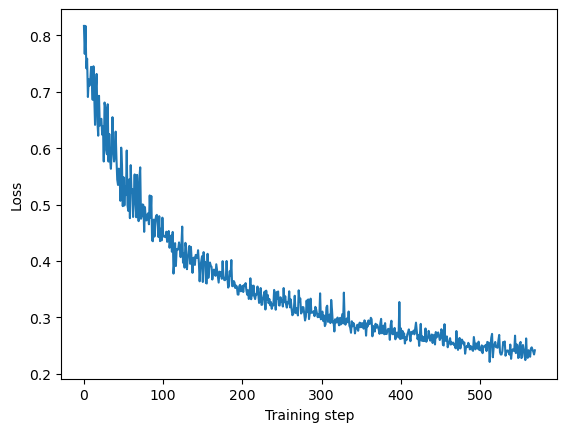

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()

Check performance on the test dataset

In [11]:
sampler_testing = WeightedRandomSampler(
    weights_testing/weights_testing.sum(),
    len(data_testing),
    replacement = True
)

loader_testing = DataLoader(data_testing, sampler=sampler_testing, batch_size=len(data_testing))

scores_testing = []
labels_testing = []

with torch.no_grad():
    for batch in loader_testing:
        scores_testing.append(model(batch))
        labels_testing.append(batch.y)

In [12]:
scores_testing = scores_testing[0][:,0]

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(labels_testing[0], scores_testing)
auc = roc_auc_score(labels_testing[0], scores_testing)

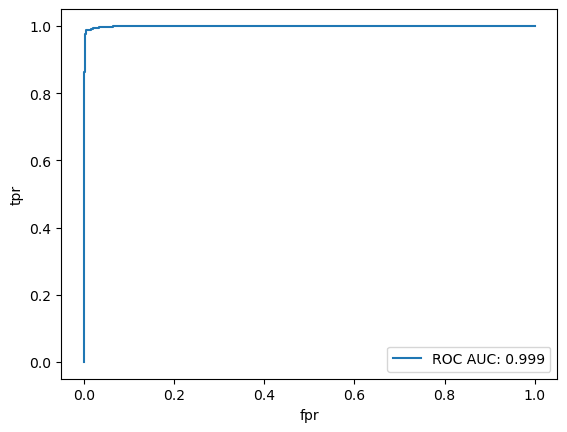

In [14]:
plt.plot(fpr, tpr, label=f"ROC AUC: {auc:.3f}")
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

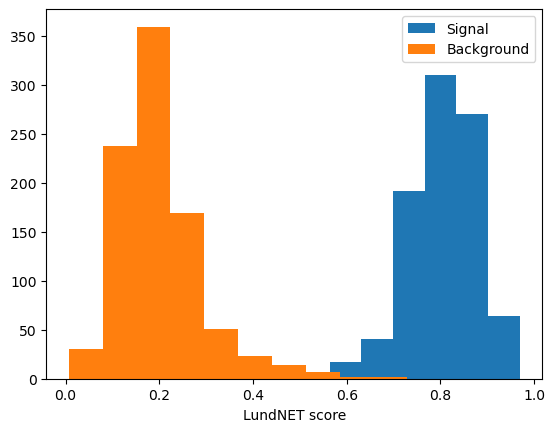

In [15]:
plt.hist(scores_testing[labels_testing[0] == 1.], label="Signal")
plt.hist(scores_testing[labels_testing[0] == 0.], label="Background")
plt.xlabel("LundNET score")
plt.legend()
plt.show()